# Urvalsalgoritm
Det här är en Jupyter Notebook som använts för att utforska algoritmer för att välja ut vilka klockor man ska lita på. Flera olika algoritmer har testats men i slutändan valde vi att använda den relativt enkla algoritmen från RFC5905 som bara letar efter överlappande tidsspann.

## Referenser

NTP selection / clustering algorithm
https://www.eecis.udel.edu/~mills/ntp/html/cluster.html
https://datatracker.ietf.org/doc/html/draft-ietf-ntp-ntpv4-algorithms-01.txt

Clock Filter Algorithm är inte riktigt relevant för roughtime eftersom man inte filtrerar mätvärden över tid vid en kallboot.  Det skulle kunna vara relevant om man kör roughtime liknande hur man brukar köra NTP så man kan få statistik över längre tid.

Clock Selection Algorithm, 4 Clustering Algorithm och 5 Clock Combining Algorithm är mer relevanta

Chronos, en metod för att hitta dåliga NTP-servrar
https://datatracker.ietf.org/doc/draft-ietf-ntp-chronos/
https://irtf.org/anrw/2018/slides-anrw18-final26.pdf

"Dynamic Fault-Tolerant Clock Synchronization," Dolev, D., J. Halpern, B. Simons, and R. Strong
https://www.researchgate.net/publication/220431747_Dynamic_Fault-Tolerant_Clock_Synchronization/link/0912f50a16f0dcf395000000/download

"Synchronizing Clocks in the Presence of Faults", LESLIE LAMPORT AND P. M. MELLIAR-SMITH
https://lamport.azurewebsites.net/pubs/clocks.pdf

"Byzantine Clock Synchronization" Leslie Lamport and P. M. Melliar-Smith
https://lamport.azurewebsites.net/pubs/clocks2.pdf

"Maintaining the Time in a Distributed System" Keith Marzullo
http://infolab.stanford.edu/pub/cstr/reports/csl/tr/83/247/CSL-TR-83-247.pdf

## Grundläggande ideer

Att bootstrappa en klocka skiljer sig en del från normalt användande av t.ex. NTP för att få tid.  Flera av artiklarna ovan bygger på att man har någorlunda koll på vad klockan är och att man bara vill justera sin lokala klocka lite när den drivit iväg från de andra klockorna.  Man kan inte heller lägga lång tid på att samla statistik om hur servrarna man frågar beter sig över tid.  I princip kan man få ett snapshot av svar från servrarna och måste ta ett beslut om vad man anser att klockan är inom ett par sekunder så man inte fördröjer boot-processen för mycket. Men en hel del av grundtankarna från framför allt NTP "selection / clustering" samt "clock combining algorithm" borde ändå gå att återanvända.

En sak att tänka på är att om man använder roughtime så är det rätt billigt att ställa roughtime-frågor genom att skicka UDP-paket.  Det är även billigt att ta emot UDP-svaren så länge man har minne nog att lagra dem i.  Det som kan ta tid på en CPU-svag plattform är att validera ed25519-signaturen och hashen, men det kan man skjuta upp så långt som möjligt.

Börja med att sätta upp ett kriterium för vad som är "bra nog".  T.ex. att man vill ha svar från minst 5 tids-servrar som max får avvika N millisekunder från varanda.

Ha en lista på "många" möjliga servrar.  Ett tjugotal borde nog vara minium.

Välj N+M slumpmässiga servrar och skicka frågor till dem.  Spara lokal transmit time samt information så man kan koppla ihop svaret man får med frågan (server och unikt ID / NONC).  M är ett par extra frågor man ställer utifall att någon server inte svarar eller eller man får svar som man av någon anledning kastar bort i senare steg.  Om M är för litet så kan man behöva ställa ytterligare frågor och måste då vänta på mer fler svar vilket fördröjer boot-processen.  Men man vill inte att M ska vara för stort heller, för då slösar man bort resurser på servrarna i onödan och har man begränsat med minne så kanske man måste kasta bort svar för att man inte hinner processa dem och inte har plats att mellanlagra dem.

Ta emot svar och lagra svaret samt lokal receive time i en tabell.  Om möjligt ska det här ske i en interrupt-hanterare så att receive time blir så exakt som möjligt.  Man skulle även kunna göra lite grundläggande validering här för att spara på minne.

Processa svaren ett efter ett.

Om man inte redan gjort grundläggande validering så gör man det här. Kontrollera att formatet på svaret är korrekt: att fält kommer i rätt ordning, att fälten inte är orimligt stora, att alla fält som ska finnas finns.  En liten optimering man skulle kunna göra här är att kasta bort svar som har "orimlig tid", t.ex. att tiddstämpeln är före firmwaren i enheten skapades, eller om den är hundra år in i framtiden.

Ta unikt IDt / NONC i svaret svaret använd det för att hitta frågan man skickat.  

Hitta servern via frågan och verifiera signatur på svaret mot serverns publika nyckel.  Logga om det inte går att hitta en fråga eller om signaturen inte går att verifiera: någon försöker sig nog på en MITM-attack.  Om alla kontroller går igenom så kan man kasta bort den ursprungliga frågan och svaret och bara spara ner den användbara informationen från frågan i ytterligare en tabell (lokal transmit time, lokal receive time, serverns tid, eventuellt en referens till vilken server för loggning).

Kontrollera om antalet verifierade svar är N eller fler.  Jämför svaren med något som är snarlikt NTPs selection/clustering algorithm.  Om alla svaren uppfyller kriteriena om att ligga nära nog alla andra svar så har man lyckats och kan stoppa loopen.  Annars identiferar man det svar som är "sämst" och kastar tillfälligt bort det.  Om antalet kvarvarande var fortfarande är N eller fler, försök igen, annars har algoritmen misslyckats så man får stoppa loopen.

Om man inte har N "bra" svar, välj ut (N + M - antalet frågor man inte fått svar på än) nya servrar och skicka frågor till dem.  Gå tillbaka och vänta på fler svar.  Om man fått slut på servrar så kan man välja att antingen försöka fråga samma servrar som man redan frågat igen eller helt enkelt ge upp.  Vilket man gör är ett policy-beslut baserat på hur viktigt det är att ha korrekt tid för den applikation man kör.

Om man har N "bra" svar så är man nästan klar.  Räkna ut ett viktat medelvärde och estimat av osäkerhet från de N "bra" svaren.  NTP "clock combining algorithm" är nog en bra utgångspunkt för det.  Nånting som tar hänsyn till osäkerhet baserat på time in flight (local receive time - transmit time) och den osäkerhet servern rapporterar (RADI).

Nu har man tid och kan gå vidare med saker som är beroende på det.


In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import scipy
import math
from pprint import pprint
import random
from importlib import reload
from collections import defaultdict

matplotlib.rcParams['figure.max_open_warning'] = 0
             
%matplotlib inline
# %matplotlib notebook

In [2]:
# Lite infrastruktur som gör koden nedan tydligare
def positive_gaussian(a, b):
    """Returnera ett positivt slumpvärde med gaussisk normalfördelning"""
    return a + abs(np.random.normal() * b)

class DictObject(dict):
    def __setattr__(self, k, v):
        self[k] = v
    def __getattr__(self, k):
        if k in self:
            return self[k]
        try:
            return self.__dict__[k]
        except KeyError as e:
            raise AttributeError(e)
            
class Measurement(DictObject):
    def shift_remote_time(self, shift):
        if 'orig_remote_time' not in self:
            self.orig_remote_time = self.remote_time
        self.remote_time = self.orig_remote_time + shift

In [15]:
# Slump-frö, gör det möjligt att upprepa samma värden
seed = np.random.randint(1<<32)
# seed = 3517864564 # lite best case
# seed = 703437070 # blir snett
seed = 2631125496
print("seed =", seed)
np.random.seed(seed)

# Skapa lite testdata
def make_measurements(N = 10, MIN_TRIP = 10, MAX_TRIP = 10):
    # Den lokala klockan börjar på 0 vid start
    local_time = 0

    # Faktisk "wall time" vid start
    wall_time = 100

    # Mätningar
    global measurements
    measurements = []

    # Ställ frågor sekvensiellt
    for i in range(N):
        m = Measurement()

        # Klienten skickar iväg en fråga
        m.local_transmit_time = local_time

        # Slumpa fram trip time från klient till server och justera både local_time och wall_time
        m.outbound_trip = positive_gaussian(MIN_TRIP, MAX_TRIP)
        local_time += m.outbound_trip
        wall_time += m.outbound_trip

        # Servern tidsstämplar paketet, som förenkling antar vi att detta inte tar någon tid och att dess klocka går perfekt rätt
        m.remote_time = wall_time

        # Slumpa fram trip time från server till klient och justera både local_time och wall_time
        m.inbound_trip = positive_gaussian(MIN_TRIP, MAX_TRIP)
        local_time += m.inbound_trip
        wall_time += m.inbound_trip

        # Klienten tar emot svaret
        m.local_receive_time = local_time

        measurements.append(m)
    
make_measurements()
  
# Notera att outbound_trip och inbound_trip är information som klienten
# inte kan känner till, det är något som vi som allvetande observatörer 
# som skapat simulationen kan se.  Allt klienten kommer känna till är 
# local_transmit_time, remote_time och local_receive_time.

# Visa tabell med mätvärden och dold information
pd.DataFrame(measurements)

seed = 2631125496


,local_transmit_time,outbound_trip,remote_time,inbound_trip,local_receive_time
0,0.000000,22.307269,122.307269,11.220754,33.528024
1,33.528024,10.391763,143.919786,12.932022,56.851808
2,56.851808,11.639781,168.491589,20.762717,89.254306
3,89.254306,15.639033,204.893339,13.222511,118.115850
4,118.115850,26.035408,244.151258,33.564879,177.716137
5,177.716137,15.732952,293.449088,18.436670,211.885759
6,211.885759,10.786345,322.672104,24.212659,246.884763
7,246.884763,21.287083,368.171846,11.018964,279.190810
8,279.190810,11.701661,390.892471,13.970593,304.863064
9,304.863064,14.956305,419.819369,15.572985,335.392354


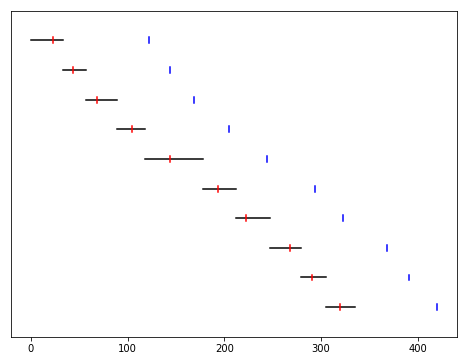

In [16]:
def plot_measurements():
    plt.figure(figsize = [ 8, 6 ])
    plt.gca().yaxis.set_visible(False)

    for i in range(len(measurements)):
        m = measurements[i]
        plt.plot([ m.local_transmit_time, m.local_receive_time ], [i,i], color = 'black', label = "RTT")
        plt.plot([ m.remote_time, m.remote_time ], [i-0.1,i+0.1], color = 'blue', label = "Remote time")
        plt.plot([ m.local_transmit_time + m.outbound_trip, m.local_transmit_time + m.outbound_trip ], [i-0.1,i+0.1], color = 'red', label = "Truth (hidden)")
    plt.ylim(len(measurements), -1)

plot_measurements()

# RTT är round trip time, lokal tid från att klienten ställde frågan tills dess att svaret kom tillbaka
# Remote time är den tidsstämpel servern skickar i sitt svar
# Actual är när servern faktiskt gjorde tidsstämpeln, den informationen kan inte klienten veta

In [17]:
def adjust_measurements():
    # Antag att midpoint mellan local_transmit_time och local_receive_time motsvarar remote_time.
    # och räkna ut adjustment som är hur mycket den lokala klockan behöver justeras för att överensstämma med det.
    # Räkna även ut true adjustment som är hur mycket klockan skulle behöva justeras om klienten hade perfekt information, vilket den inte har.
    for i in range(len(measurements)):
        m = measurements[i]
        m.rtt = m.local_receive_time - m.local_transmit_time
        m.midpoint = m.local_transmit_time + m.rtt / 2
        m.adjustment = m.remote_time - m.midpoint
        m.true_adjustment = m.remote_time - (m.local_transmit_time + m.outbound_trip)

    # Visa uträknade värden i en tabell
    return pd.DataFrame(pd.DataFrame(measurements)[['midpoint', 'rtt', 'adjustment', 'true_adjustment']])
    
adjust_measurements()

,midpoint,rtt,adjustment,true_adjustment
0,16.764012,33.528024,105.543258,100.0
1,45.189916,23.323784,98.729870,100.0
2,73.053057,32.402498,95.438532,100.0
3,103.685078,28.861544,101.208261,100.0
4,147.915993,59.600287,96.235264,100.0
5,194.800948,34.169622,98.648141,100.0
6,229.385261,34.999004,93.286843,100.0
7,263.037786,32.306047,105.134059,100.0
8,292.026937,25.672254,98.865534,100.0
9,320.127709,30.529290,99.691660,100.0


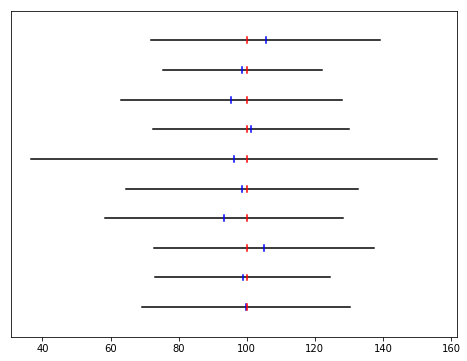

In [18]:
def plot_adjusted_measurements():
    plt.figure(figsize = [ 8, 6 ])
    plt.gca().yaxis.set_visible(False)

    for i in range(len(measurements)):
        m = measurements[i]
        plt.plot([ m.adjustment - m.rtt, m.adjustment + m.rtt ], [i,i], color = 'black', label = "Uncertainty")
        plt.plot([ m.adjustment, m.adjustment ], [i-0.1,i+0.1], color = 'blue', label = "Adjustment")
        plt.plot([ m.true_adjustment, m.true_adjustment ], [i-0.1,i+0.1], color = 'red', label = "Truth (hidden)")   
    plt.ylim(len(measurements), -1)
    
plot_adjusted_measurements()

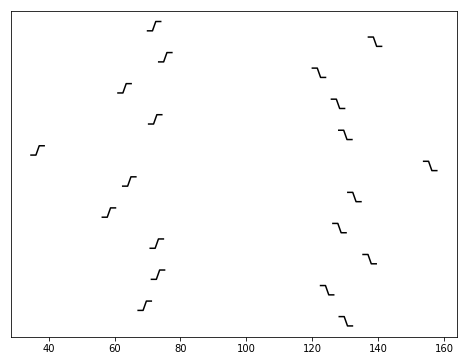

In [19]:
def create_edges():
    # Algoritm från RFC5905 A.5.5.1 för att hitta överlapp (notera att algoritmen i RFC5905 är trasig, använd rättade som finns i erratan)
    global edges
    edges = []
    for m in measurements:
        e = DictObject()
        e.value = m.adjustment - m.rtt
        e.kind = -1
        edges.append(e)

        e = DictObject()
        e.value = m.adjustment + m.rtt
        e.kind = +1
        edges.append(e)

create_edges()

def plot_edges():
    plt.figure(figsize = [ 8, 6 ])
    plt.gca().yaxis.set_visible(False)

    for i in range(len(edges)):
        e = edges[i]
        x = e.value
        d = e.kind * 0.3
        plt.plot([ x-2, x-0.5, x+0.5, x+2 ], [ i-d, i-d, i+d, i+d ], color = 'black')
    plt.ylim(len(edges), -1)

plot_edges()

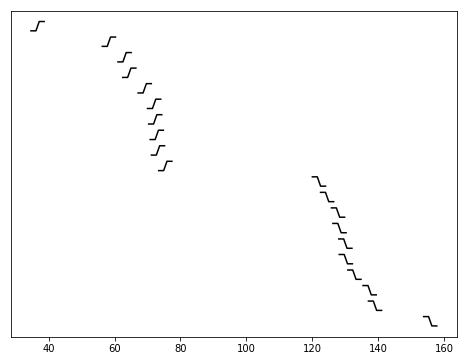

In [20]:
# Sortera edges baserat på tid
def sort_edges():
    edges.sort(key = lambda a: a.value)
    
sort_edges()
plot_edges()

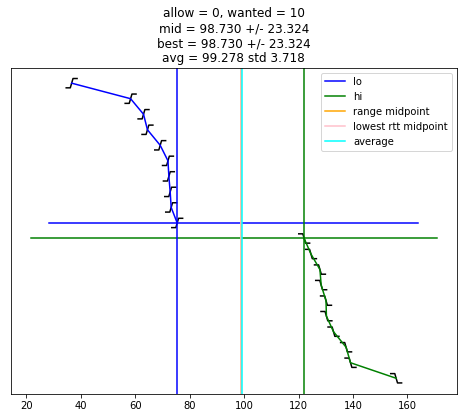

In [21]:
def selection_algorithm(max_allow = 1):
    # Kör om tidigare steg så man slipper upprepa sig senare
    adjust_measurements()
    create_edges()
    sort_edges()

    if not max_allow:
        max_allow = len(edges) // 2
    
    N = len(measurements)
    for allow in range(max_allow):
        wanted = N - allow
        found = 0

        lo_chimes = []
        hi_chimes = []

        chime = 0
        lo = None
        for e in edges:
            chime -= e.kind
            lo_chimes.append((e.value, chime))
            if chime >= wanted:
                lo = e.value
                break

        chime = 0
        hi = None
        for e in reversed(edges):
            chime += e.kind
            hi_chimes.append((e.value, chime))
            if chime >= wanted:
                hi = e.value
                break

        plot_edges()
        plt.plot([ x for (x, y) in lo_chimes ], [ y-1 for (x, y) in lo_chimes ], color = 'blue', label = "lo")
        plt.plot([ x for (x, y) in hi_chimes ], [ len(edges)-y for (x, y) in hi_chimes ], color = 'green', label = "hi")
        plt.plot(plt.xlim(), [ wanted-1, wanted-1 ], color = 'blue')
        plt.plot(plt.xlim(), [ len(edges)-wanted, len(edges)-wanted ], color = 'green')
        if lo is not None:
            plt.plot([ lo, lo ], plt.ylim(), color = 'blue')
        if hi is not None:
            plt.plot([ hi, hi ], plt.ylim(), color = 'green')

        midpoint = None
        uncertainty = None
        best_adj = None
        best_rtt = None
        avg = None
        good = None
        if lo is not None and hi is not None and lo < hi:
            midpoint = (lo + hi) / 2
            uncertainty = (hi - lo) / 2

            good = []
            for m in measurements:
                if m.adjustment >= lo and m.adjustment <= hi:
                    good.append(m.adjustment)
                    if best_rtt is None or m.rtt < best_rtt:
                        best_adj = m.adjustment
                        best_rtt = m.rtt

        s = "allow = %u, wanted = %u" % (allow, wanted)
        if midpoint is not None:
            s += "\nmid = %.3f +/- %.3f" % (midpoint, uncertainty)
            plt.plot([ midpoint, midpoint ], plt.ylim(), color = 'orange', label = "range midpoint")

        if best_adj is not None:
            s += "\nbest = %.3f +/- %.3f" % (best_adj, best_rtt)
            plt.plot([ best_adj, best_adj ], plt.ylim(), color = 'pink', label = "lowest rtt midpoint")

        if good:
            av = sum(good)/len(good)
            st = np.std(good)
            s += "\navg = %.3f std %.3f" % (av, st)
            plt.plot([ av, av ], plt.ylim(), color = 'cyan', label = "average")

        plt.title(s)      
        plt.legend()
        
selection_algorithm()

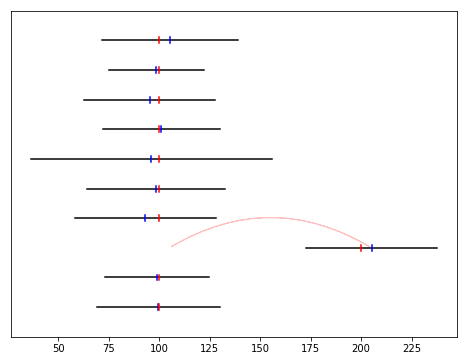

In [22]:
# En klocka går rejält fel
measurements[7].shift_remote_time(100)

adjust_measurements()
plot_adjusted_measurements()

def show_shifts():
    for i in range(len(measurements)):
        m = measurements[i]
        if 'orig_remote_time' in m:
            x0 = m.adjustment
            x1 = x0 + m.orig_remote_time - m.remote_time
            p = patches.FancyArrowPatch((x0, i), (x1, i), connectionstyle = 'arc3, rad=%s' % 0.3, color = '#ffc0c0')
            plt.gca().add_patch(p)

show_shifts()

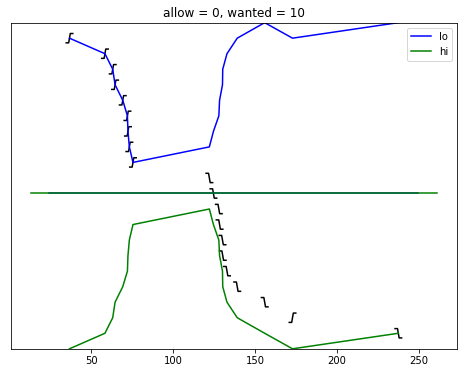

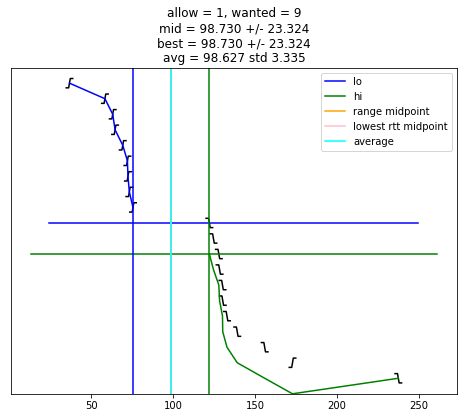

In [11]:
selection_algorithm(2)

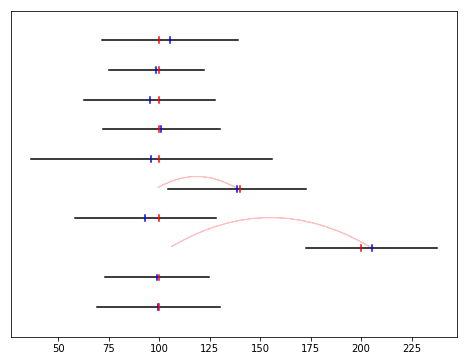

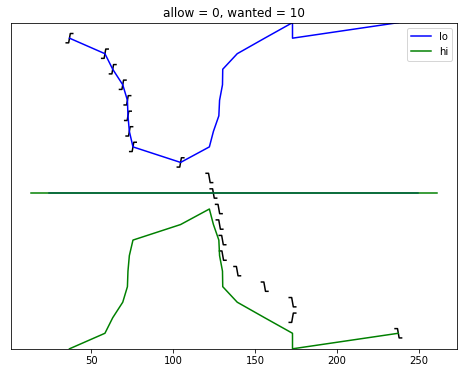

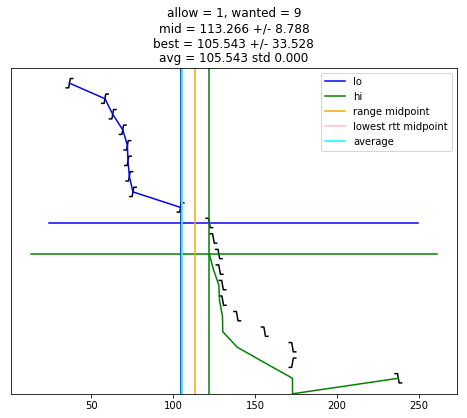

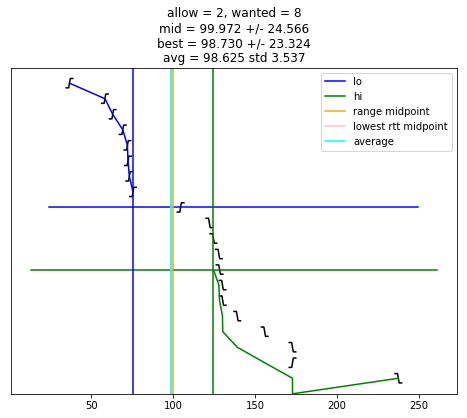

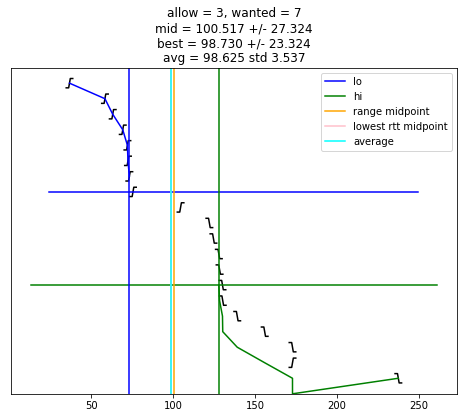

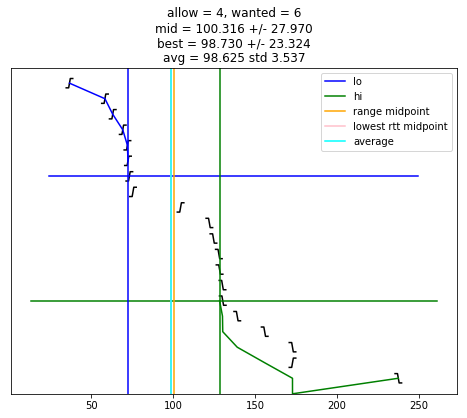

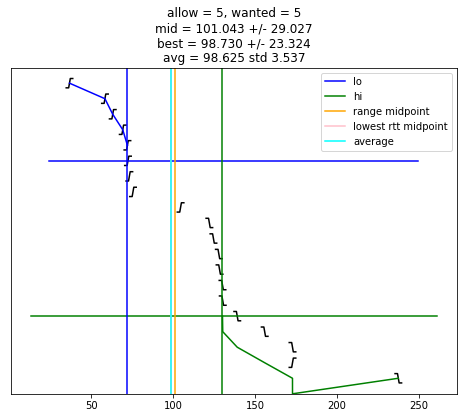

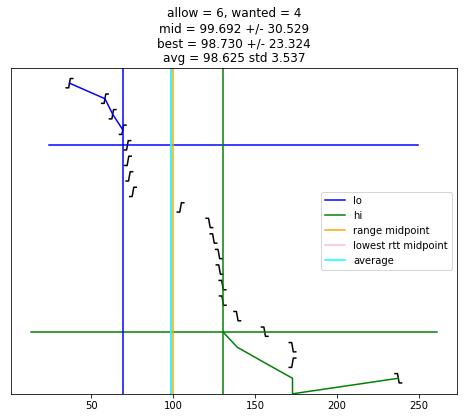

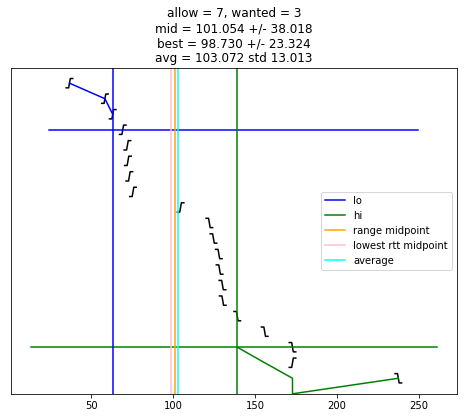

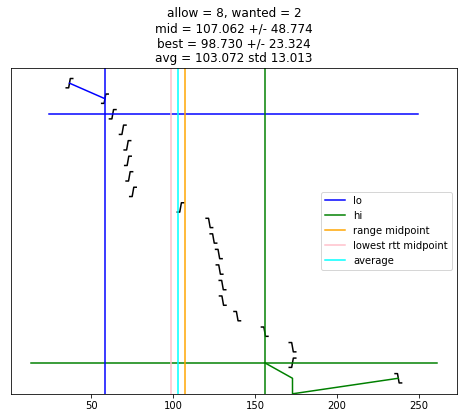

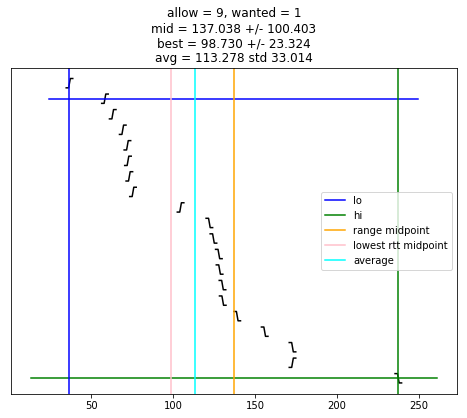

In [12]:
# Ett par av klockorna går fel men bara lite
# measurements[3].shift_remote_time(-20)
measurements[5].shift_remote_time(+40)

adjust_measurements()
plot_adjusted_measurements()
show_shifts()
selection_algorithm(10)

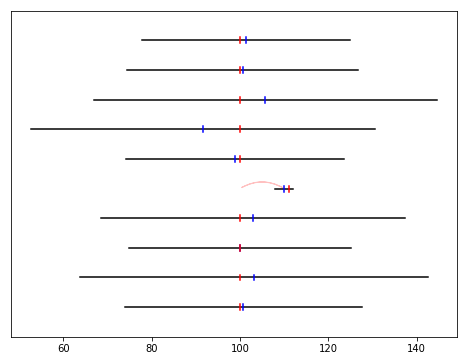

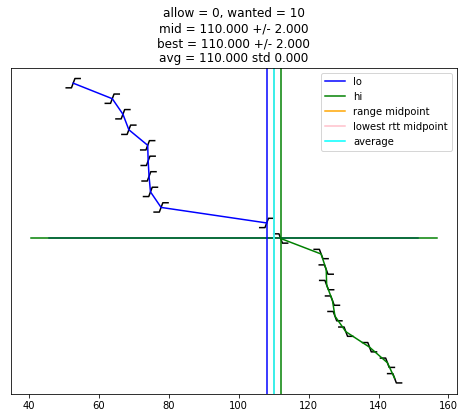

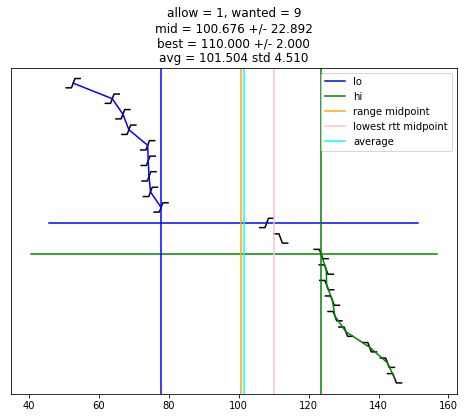

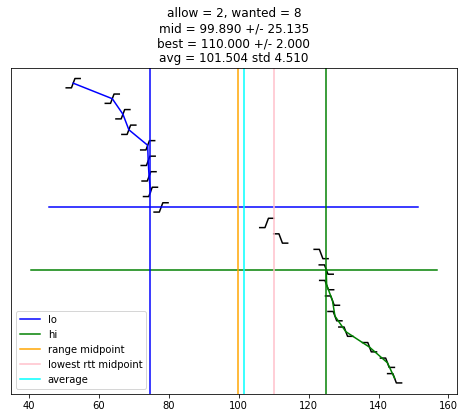

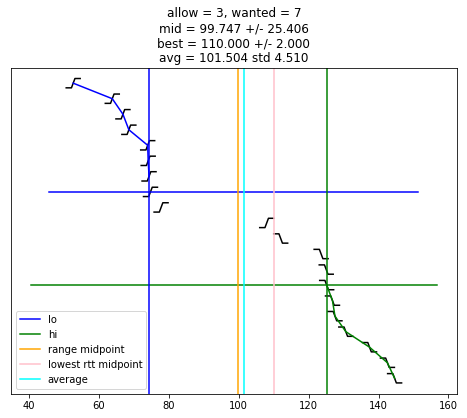

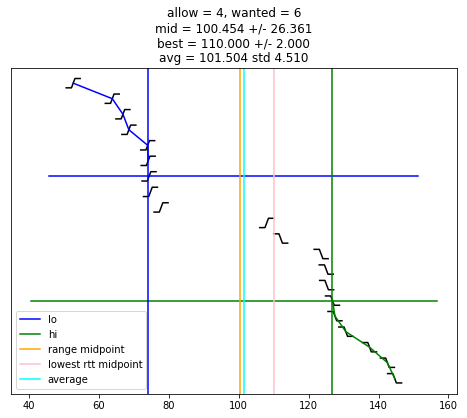

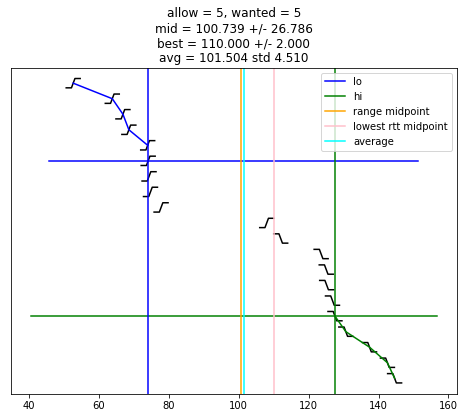

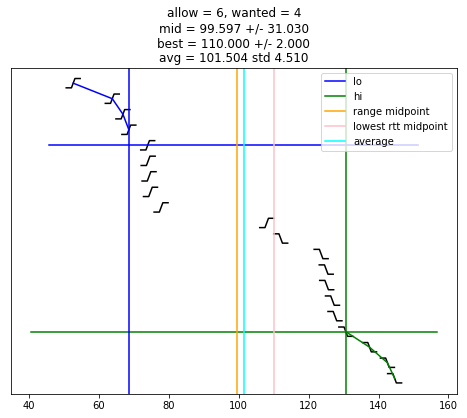

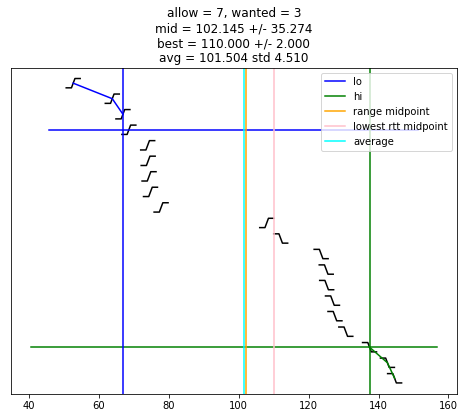

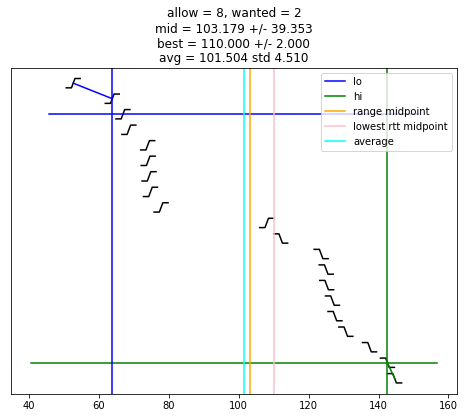

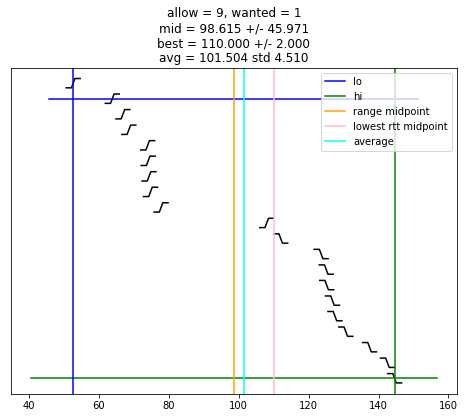

In [13]:
# En av klockorna går fel men bara lite och man har kort RTT så man litar då den.  Det ger ett rätt dåligt resultat.
# measurements[3].shift_remote_time(-20)
make_measurements()
measurements[5].shift_remote_time(+10)
mid = measurements[5].local_transmit_time + measurements[5].outbound_trip
measurements[5].outbound_trip = 0
measurements[5].local_transmit_time = mid - 1
measurements[5].local_receive_time = mid + 1

adjust_measurements()
plot_adjusted_measurements()
show_shifts()
selection_algorithm(10)